In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

import os
import argparse

from torchviz import make_dot


In [23]:
# !pip install torchviz
!pip install graphviz


Defaulting to user installation because normal site-packages is not writeable


In [24]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=1, stride=stride, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=1,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=3, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.metric = 0

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [1, 2, 2, 1])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [26]:
class CutOut(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        img: Tensor image of size (C, H, W).
        """
        h = img.size(1)
        w = img.size(2)
        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask

        return img


In [27]:
import pickle
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define the transformation for the training and test sets
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    CutOut(n_holes=1, length=16),  # Uncomment if CutOut is defined
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Function to unpickle the CIFAR-10 dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Custom Dataset class
class CIFAR10Dataset(Dataset):
    def __init__(self, file, transform=None):
        data_dict = unpickle(file)
        self.data = data_dict[b'data']
        self.labels = data_dict[b'labels']
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].reshape(3, 32, 32).transpose(1, 2, 0)
        label = self.labels[idx]

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

# Paths to the CIFAR-10 dataset files
data_path = '/scratch/aup2007/project/dl_data/cifar-10-python/cifar-10-batches-py'  # Make sure to point this to the right location of your CIFAR-10 batches
train_files = [os.path.join(data_path, 'data_batch_{}'.format(i)) for i in range(1, 6)]
test_files = os.path.join(data_path, 'test_batch')

# Creating training dataset and loader
trainset = torch.utils.data.ConcatDataset([CIFAR10Dataset(batch_file, transform=transform_train) for batch_file in train_files])
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

# Creating test dataset and loader
testset = CIFAR10Dataset(test_files, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Loading label names
meta_data = unpickle(os.path.join(data_path, 'batches.meta'))
classes = meta_data[b'label_names']
classes = [label.decode('utf-8') for label in classes]


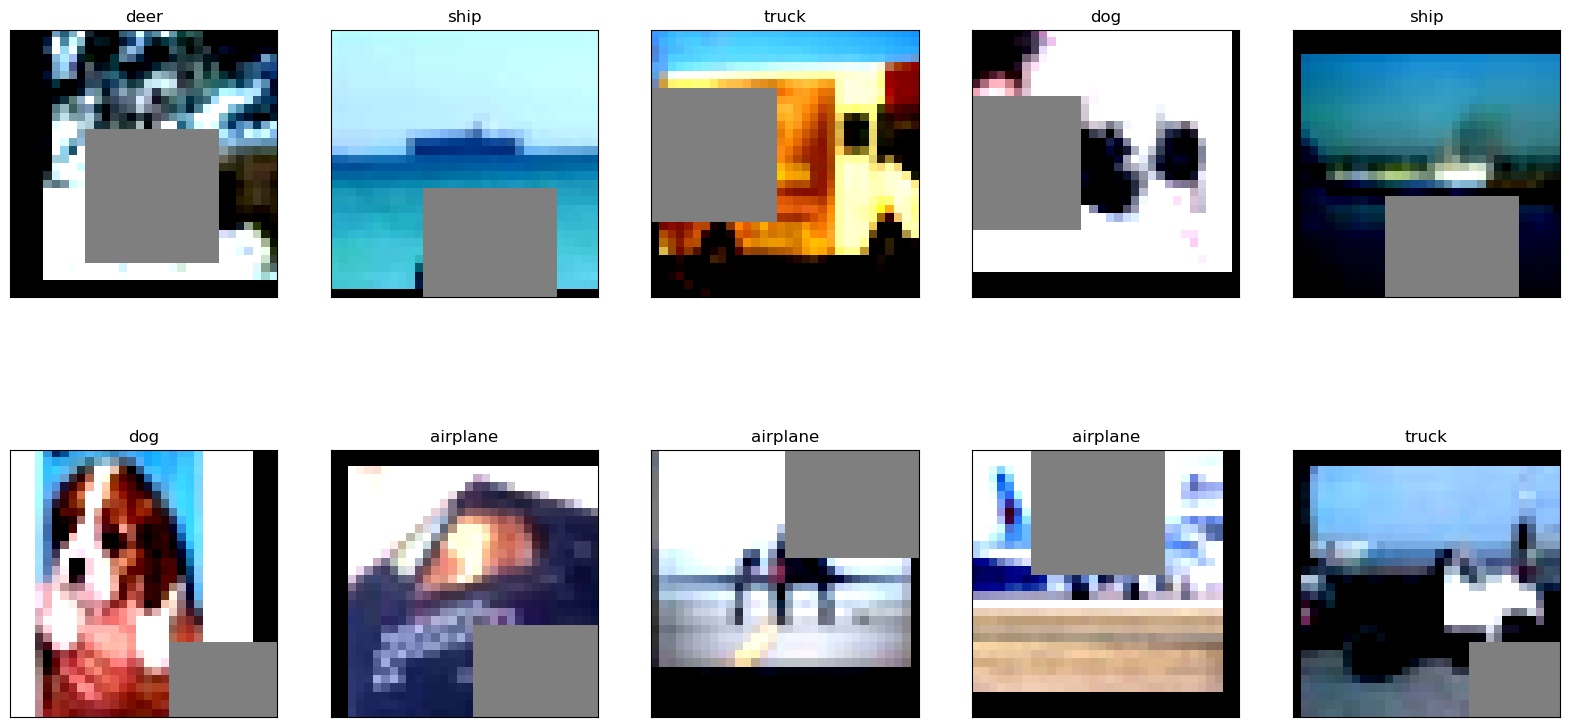

In [28]:
# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):  
  image = tensor.cpu().clone().detach().numpy() 
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

data_iterable = iter(trainloader) # converting our train_dataloader to iterable so that we can iter through it. 
images, labels = next(data_iterable) #going from 1st batch of 100 images to the next batch
fig = plt.figure(figsize=(20, 10)) 

# Plotting 10 images from the train dataset
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    
    # Note: imshow cant print tensor !
    # Lets convert tensor image to numpy using im_convert function for imshow to print the image
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [29]:
net = ResNet18()
net = net.to(device)
if device == 'cuda':
  net = torch.nn.DataParallel(net)
  cudnn.benchmark = True

In [10]:
dummy_input = torch.randn(1, 3, 32, 32)

# Forward pass with dummy input
output = net(dummy_input)

# Generate a graph of the computational graph
make_dot(output, params=dict(net.named_parameters()))#.render("resnet_torchviz", format="png")

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [30]:
from torch.optim import optimizer


def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        train_acc = 100.*correct/total
        

        #print(batch_idx, len(trainloader), 'Train Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #             % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    print("\nTrain Loss:",train_loss,"Train acc:",train_acc)
    return train_loss,train_acc

In [31]:
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            #print(batch_idx, len(testloader), 'Test Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        acc = 100.*correct/total
        print("\nValidation loss",test_loss,"Validation Acc:",acc)
    return test_loss,acc

In [32]:
import time

all_acc = []

train_loss_history_Adagrad = []
train_acc_history_Adagrad = []
val_loss_history_Adagrad = []
val_acc_history_Adagrad = []

optimizerDict = {
                    "SGD" : optim.SGD(net.parameters(), lr=0.1,
                        momentum=0.9, weight_decay=5e-4),
                    "SGDN" : optim.SGD(net.parameters(), lr=0.1,
                        momentum=0.9, nesterov = True, weight_decay=5e-4),
                    "Adam" : optim.Adam(net.parameters(),lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-4, 
                        amsgrad=False, foreach=None, maximize=False, capturable=False),
                    "Adadelta" : optim.Adadelta(net.parameters(), lr=0.1, rho=0.9, eps=1e-08, 
                        weight_decay=5e-4, foreach=None, maximize=False),
                    "Adagrad" : optim.Adagrad(net.parameters(), lr=0.01, lr_decay=0, 
                        weight_decay=5e-4, initial_accumulator_value=0, eps=1e-08, foreach=None, maximize=False)
                } 
epoch = 0
acc_array_Adagrad = []
print('==> Building model..')

early_stopping_patience = 3  # Number of epochs to wait after min has been hit
consecutive_epochs_meeting_criterion = 0  # Counter for epochs meeting the criterion
target_accuracy = 90.0

optimizer = optimizerDict["Adagrad"]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
print("Using optimizer:","Adagrad")
criterion = nn.CrossEntropyLoss()
while epoch<100:
    start_time = time.time()
    epoch+=1
    train_loss,train_acc = train(epoch)
    val_loss,val_acc = test(epoch)
    acc_array_Adagrad.append(val_acc)
    train_loss_history_Adagrad.append(train_loss)
    train_acc_history_Adagrad.append(train_acc)
    val_loss_history_Adagrad.append(val_loss)
    val_acc_history_Adagrad.append(val_acc)
    
    if val_acc >= target_accuracy:
        consecutive_epochs_meeting_criterion += 1
        if consecutive_epochs_meeting_criterion >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch}: Validation accuracy reached {val_acc}% for {consecutive_epochs_meeting_criterion} consecutive epochs.")
            break  # Stop training if condition is met
    else:
        consecutive_epochs_meeting_criterion = 0
    
    
    scheduler.step(val_loss)
    end_time = time.time()  
    elapsed_time = end_time - start_time  
    print(f'Epoch {epoch} completed in {elapsed_time:.2f} seconds.')
print(best_acc)
# all_acc.append(acc_array_Adagrad)

==> Building model..
Using optimizer: Adagrad

Epoch: 1

Train Loss: 2480.343663573265 Train acc: 41.288

Validation loss 126.40026956796646 Validation Acc: 53.23
Epoch 1 completed in 14.28 seconds.

Epoch: 2

Train Loss: 1902.2909973859787 Train acc: 55.858

Validation loss 119.5757714509964 Validation Acc: 59.53
Epoch 2 completed in 14.35 seconds.

Epoch: 3

Train Loss: 1651.6350113153458 Train acc: 62.42

Validation loss 102.35926216840744 Validation Acc: 65.39
Epoch 3 completed in 14.34 seconds.

Epoch: 4

Train Loss: 1501.5221294760704 Train acc: 65.918

Validation loss 92.26612764596939 Validation Acc: 68.46
Epoch 4 completed in 14.39 seconds.

Epoch: 5

Train Loss: 1392.8328337967396 Train acc: 68.47

Validation loss 81.53313383460045 Validation Acc: 72.08
Epoch 5 completed in 14.33 seconds.

Epoch: 6

Train Loss: 1286.4251118302345 Train acc: 71.236

Validation loss 70.89450845122337 Validation Acc: 75.93
Epoch 6 completed in 14.26 seconds.

Epoch: 7

Train Loss: 1219.036031574

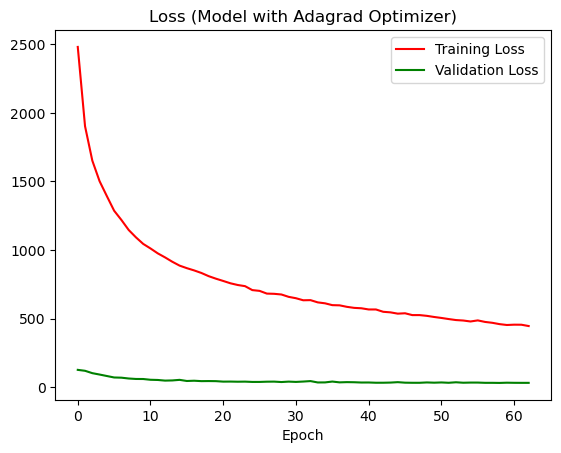

In [34]:
plt.plot(train_loss_history_Adagrad, 'r', label='Training Loss')
plt.plot(val_loss_history_Adagrad,  'g',  label='Validation Loss')
plt.xlabel("Epoch")
plt.title("Loss (Model with Adagrad Optimizer)")
plt.legend()

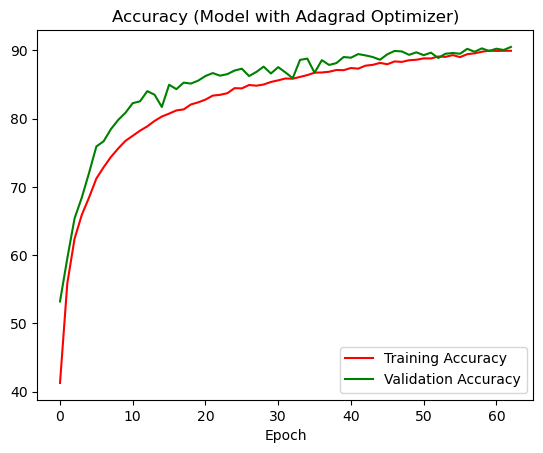

In [35]:
plt.plot(train_acc_history_Adagrad, 'r', label='Training Accuracy')
plt.plot(val_acc_history_Adagrad,  'g',  label='Validation Accuracy')
plt.xlabel("Epoch")
plt.title("Accuracy (Model with Adagrad Optimizer)")
plt.legend()

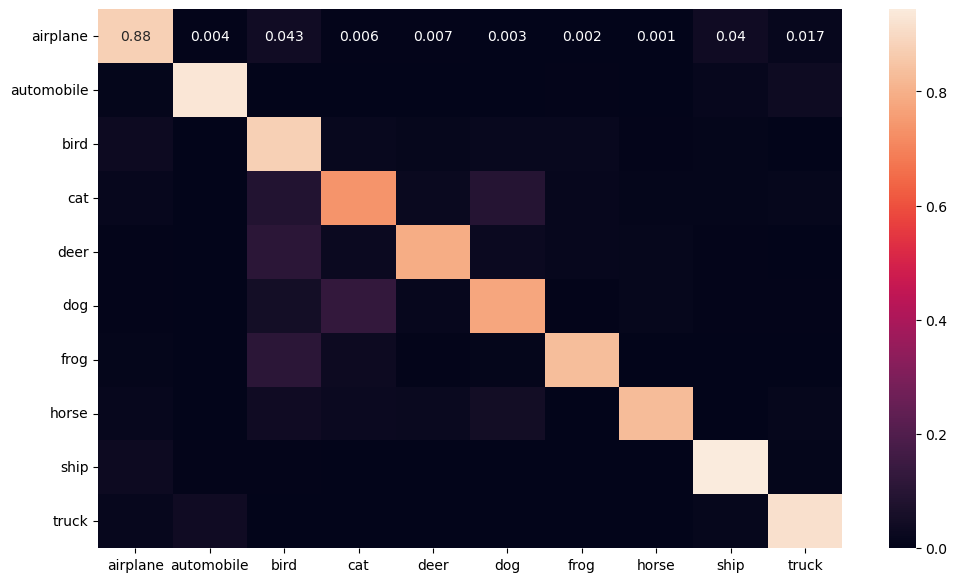

In [16]:
y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)

        _, pred = outputs.max(1)
        y_pred.extend(pred.data.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('ConfusionMatrix(Adagrad).png')

In [70]:
# total_params = 0 
# for x in filter(lambda p: p.requires_grad, net.parameters()):
#     total_params += np.prod(x.data.numpy().shape)
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(total_params)

4314954


In [17]:
acc_array_Adagrad

[51.75,
 63.93,
 66.75,
 69.51,
 65.02,
 74.19,
 77.24,
 79.32,
 79.34,
 78.23,
 81.86,
 82.92,
 82.95,
 83.49,
 83.25,
 83.75,
 85.18,
 85.31,
 83.73,
 85.34,
 86.3,
 85.46,
 85.9,
 86.75,
 84.89,
 86.68,
 86.08,
 84.68,
 87.69,
 87.17,
 88.1,
 86.2,
 87.79,
 87.77,
 87.94,
 87.78,
 88.91,
 88.19,
 88.32,
 88.38,
 88.76,
 88.31,
 88.65,
 88.95,
 88.77,
 89.32,
 89.29,
 89.42,
 89.51,
 89.02,
 89.73,
 89.18,
 89.8,
 89.1,
 89.19,
 89.94,
 89.4,
 89.82,
 89.56,
 89.53,
 89.63,
 90.09,
 91.0,
 90.94]

In [21]:
if 'net' in locals():
    del net  
    torch.cuda.empty_cache()  
net = ResNet18().to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


In [19]:
import time

all_acc = []

train_loss_history_Adadelta = []
train_acc_history_Adadelta = []
val_loss_history_Adadelta = []
val_acc_history_Adadelta = []

epoch = 0
acc_array_Adadelta = []
print('==> Building model..')

early_stopping_patience = 3  # Number of epochs to wait after min has been hit
consecutive_epochs_meeting_criterion = 0  # Counter for epochs meeting the criterion
target_accuracy = 90.0 

optimizer = optimizerDict["Adadelta"]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
print("Using optimizer:","Adadelta")
criterion = nn.CrossEntropyLoss()
while epoch<100:
    start_time = time.time()
    epoch+=1
    train_loss,train_acc = train(epoch)
    val_loss,val_acc = test(epoch)
    acc_array_Adadelta.append(val_acc)
    train_loss_history_Adadelta.append(train_loss)
    train_acc_history_Adadelta.append(train_acc)
    val_loss_history_Adadelta.append(val_loss)
    val_acc_history_Adadelta.append(val_acc)
    
    if val_acc >= target_accuracy:
        consecutive_epochs_meeting_criterion += 1
        if consecutive_epochs_meeting_criterion >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch}: Validation accuracy reached {val_acc}% for {consecutive_epochs_meeting_criterion} consecutive epochs.")
            break  # Stop training if condition is met
    else:
        consecutive_epochs_meeting_criterion = 0
    
    
    scheduler.step(val_loss)
    end_time = time.time()  
    elapsed_time = end_time - start_time  
    print(f'Epoch {epoch} completed in {elapsed_time:.2f} seconds.')
print(best_acc)
# all_acc.append(acc_array_Adadelta)

==> Building model..
Using optimizer: Adadelta

Epoch: 1

Train Loss: 3680.5884766578674 Train acc: 10.396

Validation loss 233.7996666431427 Validation Acc: 11.52
Epoch 1 completed in 13.87 seconds.

Epoch: 2

Train Loss: 3678.6762220859528 Train acc: 10.546

Validation loss 234.07239055633545 Validation Acc: 11.51
Epoch 2 completed in 13.97 seconds.

Epoch: 3

Train Loss: 3679.1717224121094 Train acc: 10.676

Validation loss 233.59740948677063 Validation Acc: 11.28
Epoch 3 completed in 13.83 seconds.

Epoch: 4

Train Loss: 3680.007734298706 Train acc: 10.588

Validation loss 233.99214267730713 Validation Acc: 11.34
Epoch 4 completed in 13.85 seconds.

Epoch: 5

Train Loss: 3680.79501080513 Train acc: 10.538

Validation loss 234.14610624313354 Validation Acc: 11.38
Epoch 5 completed in 13.87 seconds.

Epoch: 6

Train Loss: 3680.112802505493 Train acc: 10.586

Validation loss 234.10658240318298 Validation Acc: 11.4
Epoch 6 completed in 13.81 seconds.

Epoch: 7

Train Loss: 3679.6698720

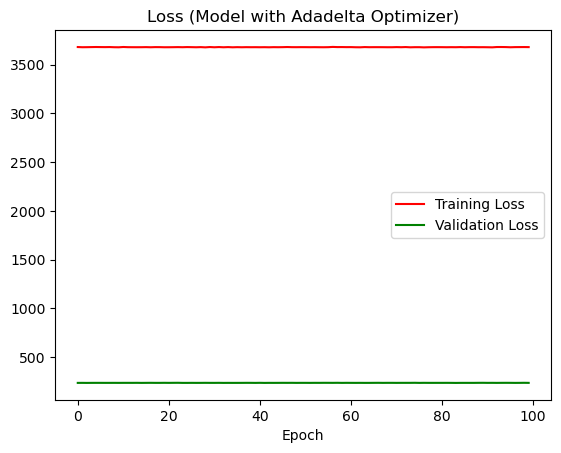

In [20]:
plt.plot(train_loss_history_Adadelta, 'r', label='Training Loss')
plt.plot(val_loss_history_Adadelta,  'g',  label='Validation Loss')
plt.xlabel("Epoch")
plt.title("Loss (Model with Adadelta Optimizer)")
plt.legend()

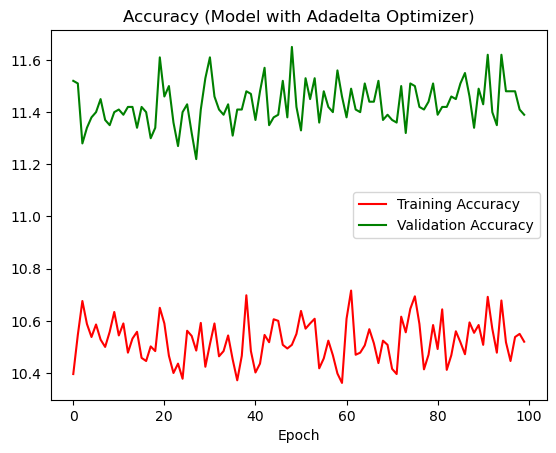

In [21]:
plt.plot(train_acc_history_Adadelta, 'r', label='Training Accuracy')
plt.plot(val_acc_history_Adadelta,  'g',  label='Validation Accuracy')
plt.xlabel("Epoch")
plt.title("Accuracy (Model with Adadelta Optimizer)")
plt.legend()

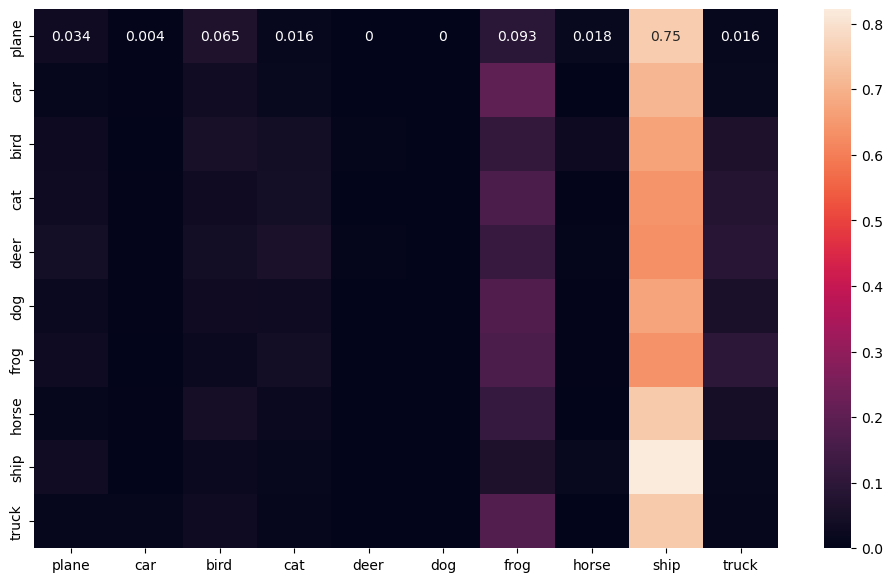

In [22]:
y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)

        _, pred = outputs.max(1)
        y_pred.extend(pred.data.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('ConfusionMatrix(Adadelta).png')

In [55]:
if 'net' in locals():
    del net  
    torch.cuda.empty_cache()  
net = ResNet18().to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


In [24]:
import time

all_acc = []

train_loss_history_Adam = []
train_acc_history_Adam = []
val_loss_history_Adam = []
val_acc_history_Adam = []


epoch = 0
acc_array_Adam = []
print('==> Building model..')

early_stopping_patience = 3  # Number of epochs to wait after min has been hit
consecutive_epochs_meeting_criterion = 0  # Counter for epochs meeting the criterion
target_accuracy = 90.0 

optimizer = optimizerDict["Adam"]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
print("Using optimizer:","Adam")
criterion = nn.CrossEntropyLoss()
while epoch<100:
    start_time = time.time()
    epoch+=1
    train_loss,train_acc = train(epoch)
    val_loss,val_acc = test(epoch)
    acc_array_Adam.append(val_acc)
    train_loss_history_Adam.append(train_loss)
    train_acc_history_Adam.append(train_acc)
    val_loss_history_Adam.append(val_loss)
    val_acc_history_Adam.append(val_acc)
    
    if val_acc >= target_accuracy:
        consecutive_epochs_meeting_criterion += 1
        if consecutive_epochs_meeting_criterion >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch}: Validation accuracy reached {val_acc}% for {consecutive_epochs_meeting_criterion} consecutive epochs.")
            break  # Stop training if condition is met
    else:
        consecutive_epochs_meeting_criterion = 0
    
    
    scheduler.step(val_loss)
    end_time = time.time()  
    elapsed_time = end_time - start_time  
    print(f'Epoch {epoch} completed in {elapsed_time:.2f} seconds.')
print(best_acc)
# all_acc.append(acc_array_Adam)

==> Building model..
Using optimizer: Adam

Epoch: 1

Train Loss: 3675.144380092621 Train acc: 9.88

Validation loss 234.14607429504395 Validation Acc: 10.88
Epoch 1 completed in 13.86 seconds.

Epoch: 2

Train Loss: 3675.9550457000732 Train acc: 9.688

Validation loss 234.0828869342804 Validation Acc: 10.83
Epoch 2 completed in 13.79 seconds.

Epoch: 3

Train Loss: 3674.223649263382 Train acc: 9.97

Validation loss 234.20159816741943 Validation Acc: 10.71
Epoch 3 completed in 13.74 seconds.

Epoch: 4

Train Loss: 3675.092418909073 Train acc: 9.86

Validation loss 233.71050715446472 Validation Acc: 10.62
Epoch 4 completed in 13.84 seconds.

Epoch: 5

Train Loss: 3675.497816801071 Train acc: 9.756

Validation loss 233.9724419116974 Validation Acc: 10.68
Epoch 5 completed in 13.77 seconds.

Epoch: 6

Train Loss: 3674.8679625988007 Train acc: 9.834

Validation loss 233.868426322937 Validation Acc: 10.65
Epoch 6 completed in 13.83 seconds.

Epoch: 7

Train Loss: 3674.753974199295 Train acc

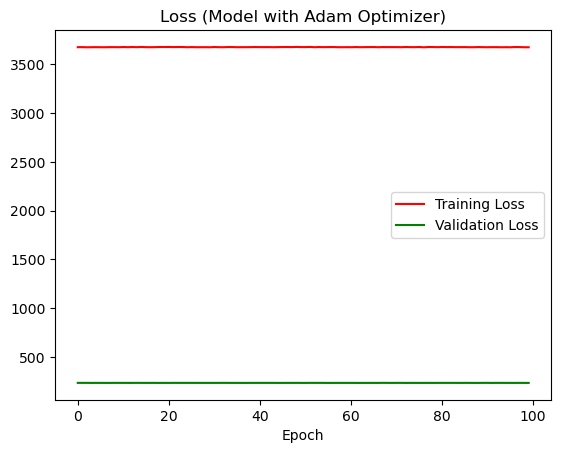

In [25]:
plt.plot(train_loss_history_Adam, 'r', label='Training Loss')
plt.plot(val_loss_history_Adam,  'g',  label='Validation Loss')
plt.xlabel("Epoch")
plt.title("Loss (Model with Adam Optimizer)")
plt.legend()

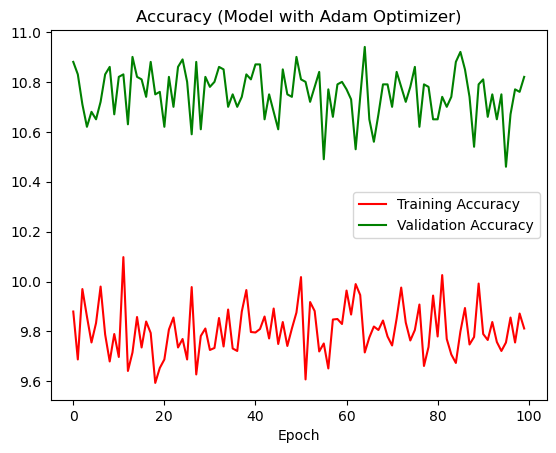

In [26]:
plt.plot(train_acc_history_Adam, 'r', label='Training Accuracy')
plt.plot(val_acc_history_Adam,  'g',  label='Validation Accuracy')
plt.xlabel("Epoch")
plt.title("Accuracy (Model with Adam Optimizer)")
plt.legend()

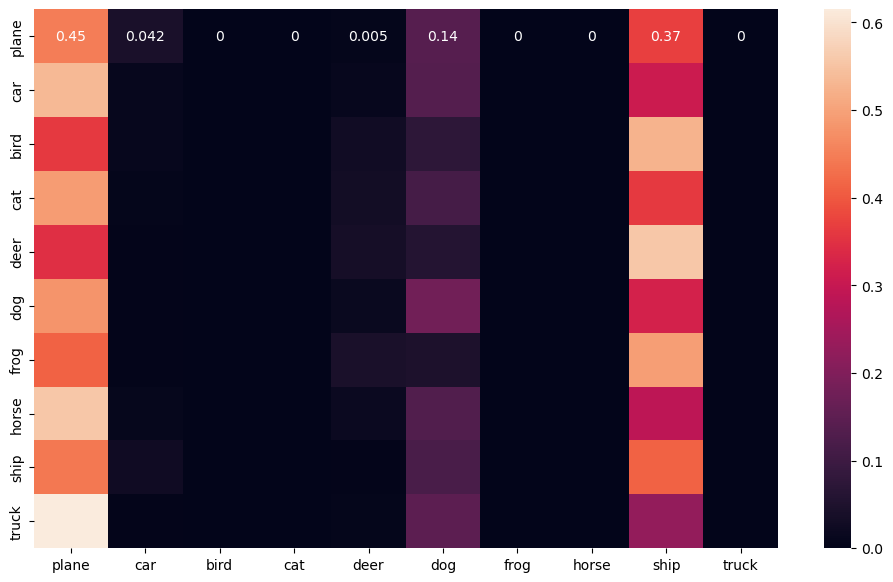

In [27]:
y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)

        _, pred = outputs.max(1)
        y_pred.extend(pred.data.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('ConfusionMatrix(Adam).png')

In [28]:
if 'net' in locals():
    del net  
    torch.cuda.empty_cache()  
net = ResNet18().to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


In [29]:
import time

all_acc = []

train_loss_history_SGDN = []
train_acc_history_SGDN = []
val_loss_history_SGDN = []
val_acc_history_SGDN = []


epoch = 0
acc_array_SGDN = []
print('==> Building model..')

early_stopping_patience = 3  # Number of epochs to wait after min has been hit
consecutive_epochs_meeting_criterion = 0  # Counter for epochs meeting the criterion
target_accuracy = 90.0 

optimizer = optimizerDict["SGDN"]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
print("Using optimizer:","SGDN")
criterion = nn.CrossEntropyLoss()
while epoch<100:
    start_time = time.time()
    epoch+=1
    train_loss,train_acc = train(epoch)
    val_loss,val_acc = test(epoch)
    acc_array_SGDN.append(val_acc)
    train_loss_history_SGDN.append(train_loss)
    train_acc_history_SGDN.append(train_acc)
    val_loss_history_SGDN.append(val_loss)
    val_acc_history_SGDN.append(val_acc)
    
    if val_acc >= target_accuracy:
        consecutive_epochs_meeting_criterion += 1
        if consecutive_epochs_meeting_criterion >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch}: Validation accuracy reached {val_acc}% for {consecutive_epochs_meeting_criterion} consecutive epochs.")
            break  # Stop training if condition is met
    else:
        consecutive_epochs_meeting_criterion = 0
    
    
    scheduler.step(val_loss)
    end_time = time.time()  
    elapsed_time = end_time - start_time  
    print(f'Epoch {epoch} completed in {elapsed_time:.2f} seconds.')
print(best_acc)
# all_acc.append(acc_array_SGDN)

==> Building model..
Using optimizer: SGDN

Epoch: 1

Train Loss: 3673.7326555252075 Train acc: 11.148

Validation loss 236.46589016914368 Validation Acc: 11.0
Epoch 1 completed in 13.84 seconds.

Epoch: 2

Train Loss: 3675.4907727241516 Train acc: 10.99

Validation loss 236.3237133026123 Validation Acc: 10.92
Epoch 2 completed in 13.80 seconds.

Epoch: 3

Train Loss: 3675.5250585079193 Train acc: 11.032

Validation loss 236.28756713867188 Validation Acc: 10.8
Epoch 3 completed in 13.72 seconds.

Epoch: 4

Train Loss: 3676.2976043224335 Train acc: 10.936

Validation loss 236.32475471496582 Validation Acc: 10.86
Epoch 4 completed in 13.80 seconds.

Epoch: 5

Train Loss: 3675.340108156204 Train acc: 10.916

Validation loss 236.04935956001282 Validation Acc: 10.76
Epoch 5 completed in 13.77 seconds.

Epoch: 6

Train Loss: 3674.150503873825 Train acc: 11.056

Validation loss 236.3809974193573 Validation Acc: 10.74
Epoch 6 completed in 13.72 seconds.

Epoch: 7

Train Loss: 3675.635372161865

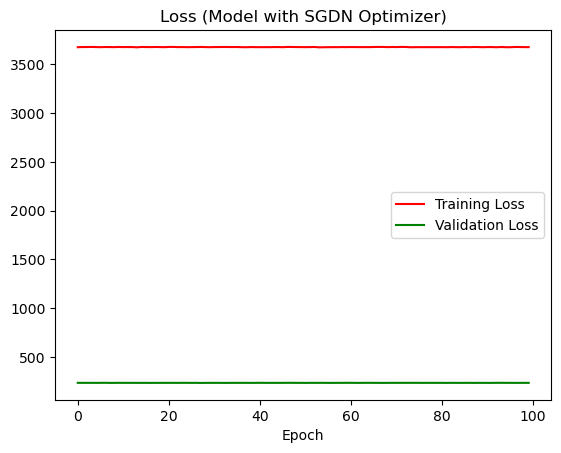

In [30]:
plt.plot(train_loss_history_SGDN, 'r', label='Training Loss')
plt.plot(val_loss_history_SGDN,  'g',  label='Validation Loss')
plt.xlabel("Epoch")
plt.title("Loss (Model with SGDN Optimizer)")
plt.legend()

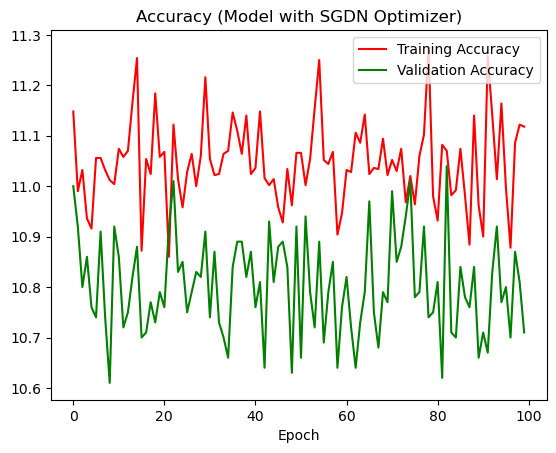

In [31]:
plt.plot(train_acc_history_SGDN, 'r', label='Training Accuracy')
plt.plot(val_acc_history_SGDN,  'g',  label='Validation Accuracy')
plt.xlabel("Epoch")
plt.title("Accuracy (Model with SGDN Optimizer)")
plt.legend()

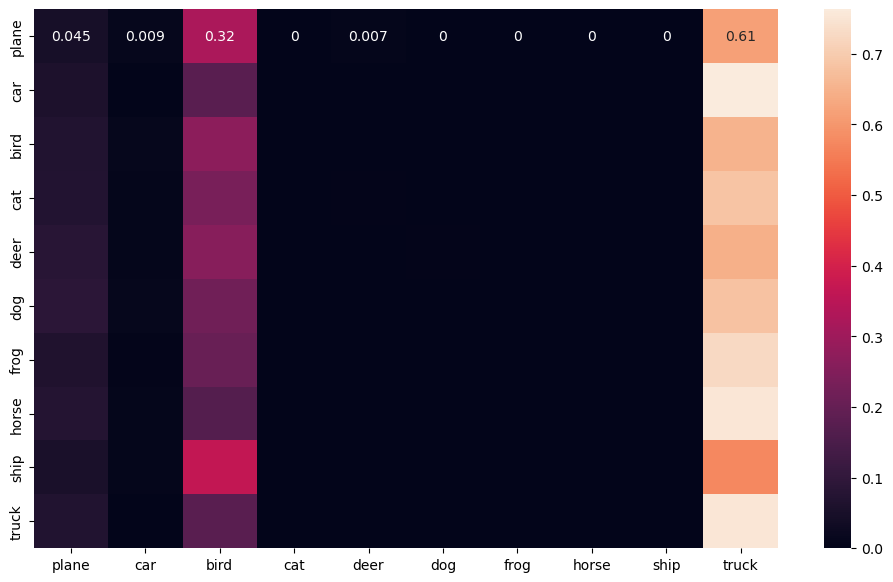

In [32]:
y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)

        _, pred = outputs.max(1)
        y_pred.extend(pred.data.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('ConfusionMatrix(SGDN).png')

In [33]:
if 'net' in locals():
    del net  
    torch.cuda.empty_cache()  
net = ResNet18().to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


In [34]:
import time

all_acc = []

train_loss_history_SGD = []
train_acc_history_SGD = []
val_loss_history_SGD = []
val_acc_history_SGD = []


epoch = 0
acc_array_SGD = []
print('==> Building model..')

early_stopping_patience = 3  # Number of epochs to wait after min has been hit
consecutive_epochs_meeting_criterion = 0  # Counter for epochs meeting the criterion
target_accuracy = 90.0 

optimizer = optimizerDict["SGD"]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
print("Using optimizer:","SGD")
criterion = nn.CrossEntropyLoss()
while epoch<100:
    start_time = time.time()
    epoch+=1
    train_loss,train_acc = train(epoch)
    val_loss,val_acc = test(epoch)
    acc_array_SGD.append(val_acc)
    train_loss_history_SGD.append(train_loss)
    train_acc_history_SGD.append(train_acc)
    val_loss_history_SGD.append(val_loss)
    val_acc_history_SGD.append(val_acc)
    
    if val_acc >= target_accuracy:
        consecutive_epochs_meeting_criterion += 1
        if consecutive_epochs_meeting_criterion >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch}: Validation accuracy reached {val_acc}% for {consecutive_epochs_meeting_criterion} consecutive epochs.")
            break  # Stop training if condition is met
    else:
        consecutive_epochs_meeting_criterion = 0
    
    
    scheduler.step(val_loss)
    end_time = time.time()  
    elapsed_time = end_time - start_time  
    print(f'Epoch {epoch} completed in {elapsed_time:.2f} seconds.')
print(best_acc)
# all_acc.append(acc_array_SGD)

==> Building model..
Using optimizer: SGD

Epoch: 1

Train Loss: 3666.3044703006744 Train acc: 10.476

Validation loss 234.44080209732056 Validation Acc: 9.98
Epoch 1 completed in 13.80 seconds.

Epoch: 2

Train Loss: 3668.137078523636 Train acc: 10.256

Validation loss 234.50483345985413 Validation Acc: 9.75
Epoch 2 completed in 13.76 seconds.

Epoch: 3

Train Loss: 3667.028487443924 Train acc: 10.216

Validation loss 234.54609966278076 Validation Acc: 9.85
Epoch 3 completed in 13.77 seconds.

Epoch: 4

Train Loss: 3665.5212433338165 Train acc: 10.276

Validation loss 234.37765336036682 Validation Acc: 9.78
Epoch 4 completed in 13.87 seconds.

Epoch: 5

Train Loss: 3665.6958181858063 Train acc: 10.224

Validation loss 234.45016741752625 Validation Acc: 9.8
Epoch 5 completed in 13.71 seconds.

Epoch: 6

Train Loss: 3667.813655614853 Train acc: 10.296

Validation loss 234.7203049659729 Validation Acc: 9.81
Epoch 6 completed in 13.79 seconds.

Epoch: 7

Train Loss: 3667.51322555542 Train

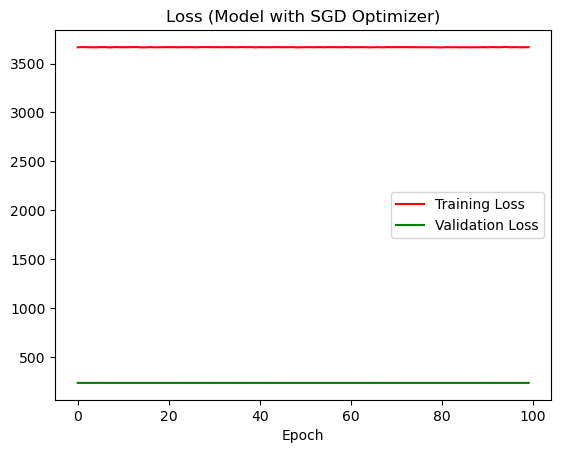

In [35]:
plt.plot(train_loss_history_SGD, 'r', label='Training Loss')
plt.plot(val_loss_history_SGD,  'g',  label='Validation Loss')
plt.xlabel("Epoch")
plt.title("Loss (Model with SGD Optimizer)")
plt.legend()

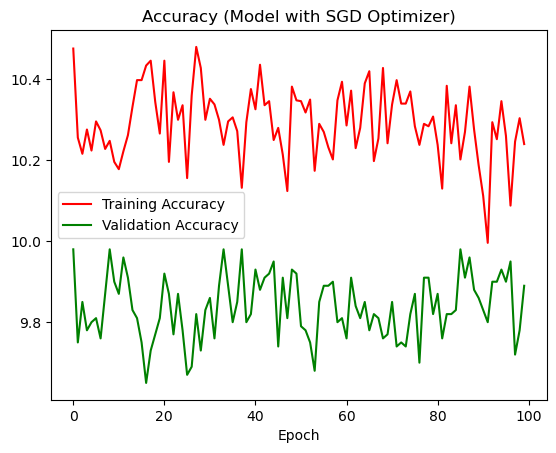

In [36]:
plt.plot(train_acc_history_SGD, 'r', label='Training Accuracy')
plt.plot(val_acc_history_SGD,  'g',  label='Validation Accuracy')
plt.xlabel("Epoch")
plt.title("Accuracy (Model with SGD Optimizer)")
plt.legend()

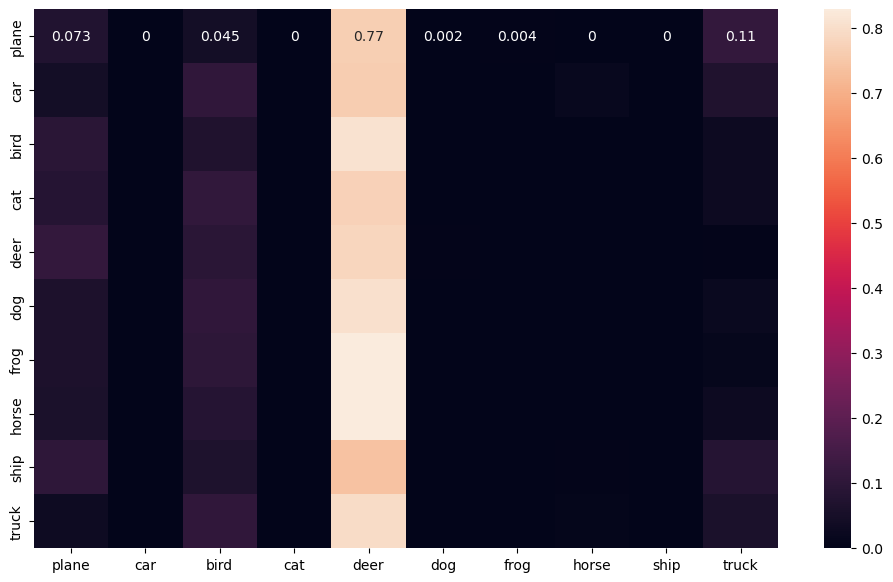

In [37]:
y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)

        _, pred = outputs.max(1)
        y_pred.extend(pred.data.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('ConfusionMatrix(SGD).png')

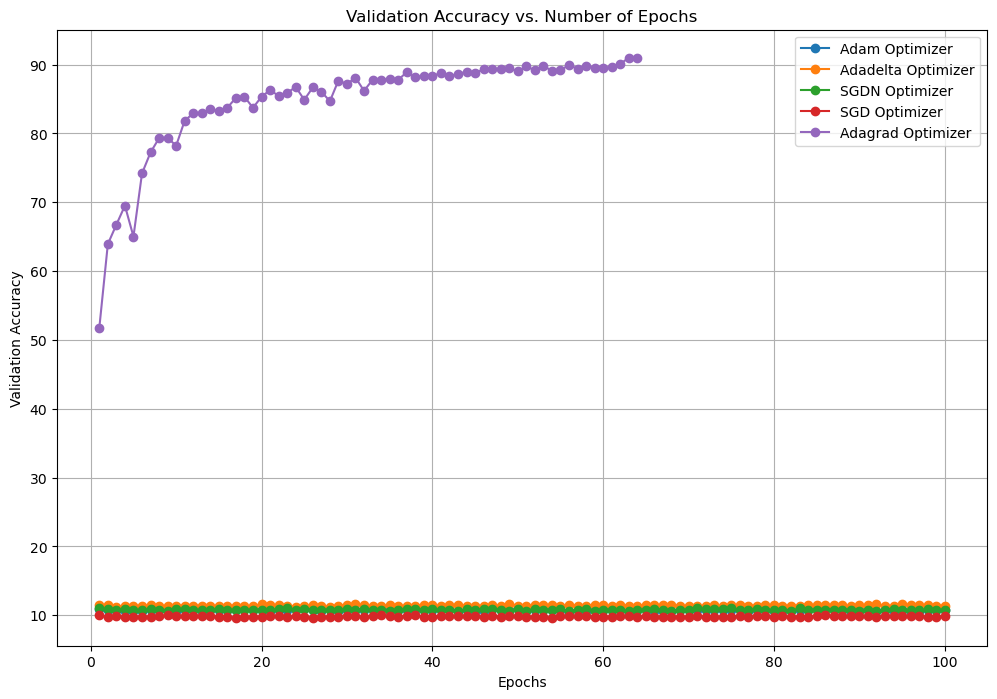

<Figure size 640x480 with 0 Axes>

In [38]:
import matplotlib.pyplot as plt

def plot_optimizer_accuracy(accuracy, label):
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, marker='o', linestyle='-', label=label)
    
plt.figure(figsize=(12, 8))

# Plotting the data for each optimizer
plot_optimizer_accuracy(val_acc_history_Adam, 'Adam Optimizer')
plot_optimizer_accuracy(val_acc_history_Adadelta, 'Adadelta Optimizer')
plot_optimizer_accuracy(val_acc_history_SGDN, 'SGDN Optimizer')
plot_optimizer_accuracy(val_acc_history_SGD, 'SGD Optimizer')
plot_optimizer_accuracy(val_acc_history_Adagrad, 'Adagrad Optimizer')

plt.title('Validation Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('validation_accuracy_vs_epochs.png', dpi=300)


In [36]:
import csv

net.eval()
with open('90_cutout_pred.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'Labels']) 

    with torch.no_grad():  
        for i, (inputs, _) in enumerate(testloader):
            inputs = inputs.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)

            for idx, pred in enumerate(predicted):
                image_id = i * len(inputs) + idx  
                writer.writerow([image_id, pred.item()])  

print("CSV file created: '90_cutout_pred.csv'")


CSV file created: '90_cutout_pred.csv'
